In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.0 MB/s eta 0:00:00


In [186]:
import os
import pydicom
import hashlib
from PIL import Image
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
import seaborn as sns

# Analyze datasets

In [73]:
pano_path = "/content/drive/MyDrive/data_all_fin/pano"
peri_path = "/content/drive/MyDrive/data_all_fin/peri"
datasets_csv_path = "/content/drive/MyDrive/data_all_fin/csv_folder/combined_metadata_boneloss.csv"

In [74]:
pano_count = sum(1 for file in os.listdir(pano_path) if file.endswith(".jpg"))
peri_count = sum(1 for file in os.listdir(peri_path) if file.endswith(".jpg"))

print(pano_count)
print(peri_count)

189
146


In [75]:
datasets_df = pd.read_csv(datasets_csv_path)
display(datasets_df)

,Unnamed: 0.1,Unnamed: 0,img_type,id,txt_fname,Filename,Specific Character Set,Image Type,Instance Creation Date,Instance Creation Time,...,Field of View Rotation,Field of View Horizontal Flip,img_filename,Spatial Resolution,Acquisition Device Processing Code,X-Ray Tube Current in uA,Patient's Age,Object Sequence,Bone Loss %,boneloss_class
0,0,0,pano,5613828_020422_0,5613828_020422_0.txt,5613828_020422_0.dcm,ISO_IR 100,ORIGINAL,20250320.0,112620.000489,...,NaN,NaN,5613828_020422_0.jpg,NaN,NaN,NaN,NaN,1,0.27,1
1,1,1,pano,5613828_020422_0,5613828_020422_0.txt,5613828_020422_0.dcm,ISO_IR 100,ORIGINAL,20250320.0,112620.000489,...,NaN,NaN,5613828_020422_0.jpg,NaN,NaN,NaN,NaN,2,0.29,1
2,2,2,pano,5917597_052724_0,5917597_052724_0.txt,5917597_052724_0.dcm,ISO_IR 100,ORIGINAL,20250320.0,124136.000998,...,NaN,NaN,5917597_052724_0.jpg,NaN,NaN,NaN,NaN,1,3.97,1
3,3,3,pano,5917597_052724_0,5917597_052724_0.txt,5917597_052724_0.dcm,ISO_IR 100,ORIGINAL,20250320.0,124136.000998,...,NaN,NaN,5917597_052724_0.jpg,NaN,NaN,NaN,NaN,2,13.44,1
4,4,4,pano,5419656_102821_2,5419656_102821_2.txt,5419656_102821_2.dcm,ISO_IR 100,ORIGINAL,20250320.0,130437.000851,...,NaN,NaN,5419656_102821_2.jpg,NaN,NaN,NaN,NaN,1,0.53,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,784,784,peri,5420736_081922_39,5420736_081922_39.txt,5420736_081922_39.dcm,ISO_IR 100,"['ORIGINAL', 'PRIMARY']",NaN,NaN,...,NaN,NaN,5420736_081922_39.jpg,NaN,NaN,NaN,NaN,2,12.71,1
746,785,785,peri,5420736_100319_16,5420736_100319_16.txt,5420736_100319_16.dcm,ISO_IR 100,"['ORIGINAL', 'PRIMARY']",NaN,NaN,...,NaN,NaN,5420736_100319_16.jpg,NaN,NaN,NaN,NaN,1,7.84,1
747,786,786,peri,5420736_111921_32,5420736_111921_32.txt,5420736_111921_32.dcm,ISO_IR 100,"['ORIGINAL', 'PRIMARY']",NaN,NaN,...,NaN,NaN,5420736_111921_32.jpg,NaN,NaN,NaN,NaN,1,0.26,1
748,787,787,peri,5420736_061917_7,5420736_061917_7.txt,5420736_061917_7.dcm,ISO_IR 100,"['ORIGINAL', 'PRIMARY']",NaN,NaN,...,0.0,NO,5420736_061917_7.jpg,NaN,NaN,NaN,NaN,1,0.81,1


In [76]:
total_files = datasets_df['Filename'].nunique()
print(total_files)

335


In [77]:
unique_class = datasets_df['boneloss_class'].nunique()
print(unique_class)

4


## Check duplicate

In [9]:
def hash_image(image_path):
    """Generate a hash for an image file."""
    with Image.open(image_path) as img:
        img = img.convert('RGB')  # Ensure consistent format
        resized = img.resize((100, 100))  # Resize for consistency and speed
        img_bytes = resized.tobytes()
        return hashlib.md5(img_bytes).hexdigest()

def find_duplicate_images(folder_path):
    """Check for duplicate images in a folder and print them."""
    hashes = {}
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            try:
                img_hash = hash_image(file_path)
                if img_hash in hashes:
                    print(f"Duplicate found:\n  {file_path}\n  {hashes[img_hash]}\n")
                else:
                    hashes[img_hash] = file_path
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

In [10]:
find_duplicate_images(pano_path)

In [11]:
find_duplicate_images(peri_path)

## Concern
1. same HN must be in only train or test
3. number of implant should be around the same ratio as config train : val : test = 80 : 10 : 10
4. train, val, and test must have at least 1 implant in every levels

### Distribution of Pano + Peri

In [78]:
# Group by "Patient ID" and aggregate the counts
uniqueHN_df = datasets_df.groupby("Patient ID").agg(
    pano_count = ("img_type", lambda x: np.sum(x == "pano")),
    peri_count = ("img_type", lambda x: np.sum(x == "peri")),
    implant_count = ("img_type", "count"),
    level1 = ("boneloss_class", lambda x: np.sum(x == 1)),
    level2 = ("boneloss_class", lambda x: np.sum(x == 2)),
    level3 = ("boneloss_class", lambda x: np.sum(x == 3)),
    level4 = ("boneloss_class", lambda x: np.sum(x == 4))
).reset_index()
uniqueHN_df = uniqueHN_df.rename(columns={"Patient ID": "uniqueHN"})
uniqueHN_df["uniqueHN"] = uniqueHN_df["uniqueHN"].str.replace("-", "", regex=False)

In [80]:
display(uniqueHN_df)

,uniqueHN,pano_count,peri_count,implant_count,level1,level2,level3,level4
0,4112969,2,0,2,1,1,0,0
1,4113591,2,0,2,1,1,0,0
2,4113618,14,0,14,14,0,0,0
3,417543,3,0,3,0,3,0,0
4,4213295,2,0,2,2,0,0,0
...,...,...,...,...,...,...,...,...
96,655212,1,0,1,1,0,0,0
97,659796,1,0,1,1,0,0,0
98,6610915,2,5,7,6,1,0,0
99,669050,3,0,3,3,0,0,0


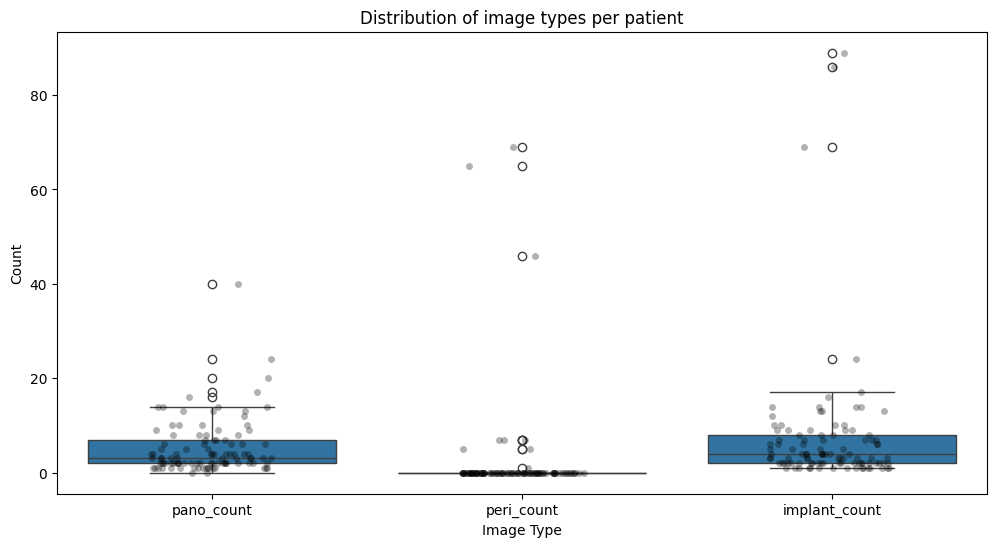

In [93]:
# Set up the figure
plt.figure(figsize=(12, 6))

# Melt the dataframe for seaborn
melted_df = uniqueHN_df.melt(id_vars="uniqueHN", value_vars=["pano_count", "peri_count", "implant_count"],
                             var_name="Image Type", value_name="Count")

# Plot
sns.boxplot(x="Image Type", y="Count", data=melted_df)
sns.stripplot(x="Image Type", y="Count", data=melted_df, color="black", alpha=0.3, jitter=0.2)
plt.title("Distribution of image types per patient")
plt.show()


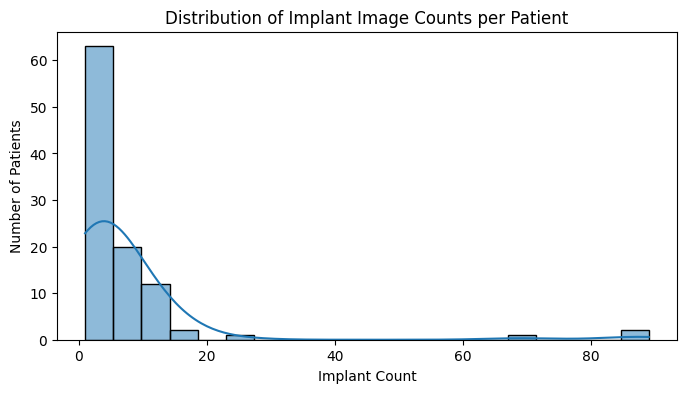

In [94]:
plt.figure(figsize=(8, 4))
sns.histplot(uniqueHN_df["implant_count"], bins=20, kde=True)
plt.title("Distribution of Implant Image Counts per Patient")
plt.xlabel("Implant Count")
plt.ylabel("Number of Patients")
plt.show()


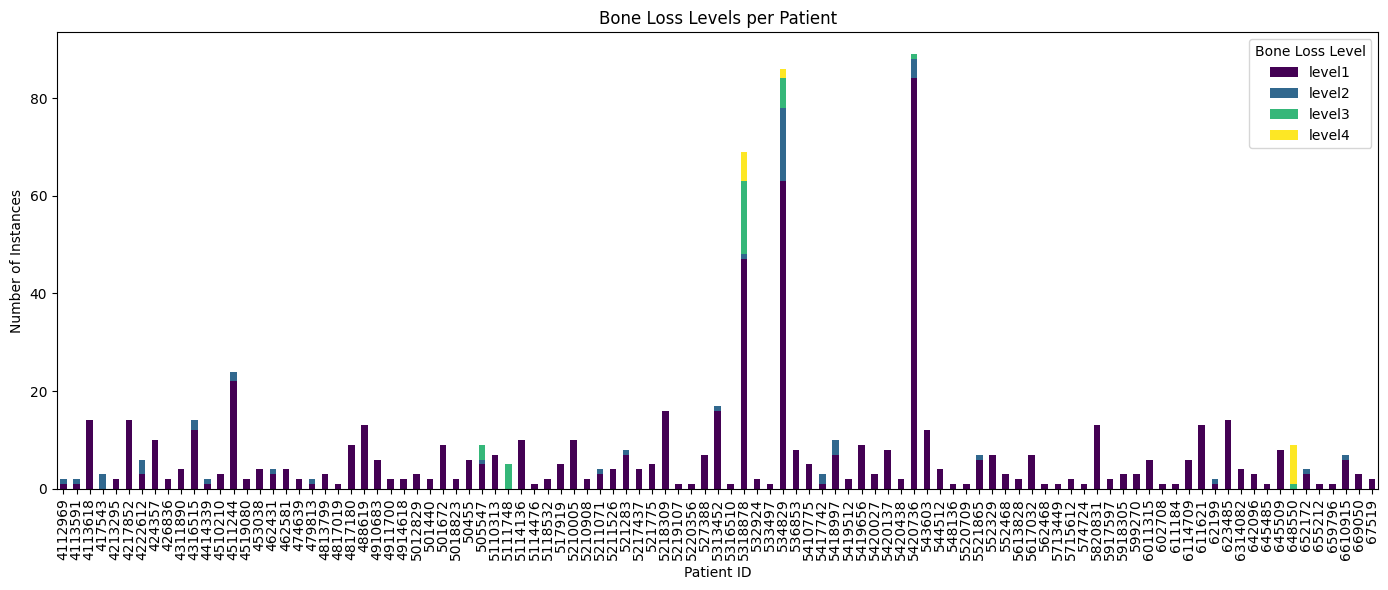

In [95]:
# Create a new dataframe for stacked bar plot
bone_levels_df = uniqueHN_df[["uniqueHN", "level1", "level2", "level3", "level4"]].set_index("uniqueHN")

# Plot
bone_levels_df.plot(kind="bar", stacked=True, figsize=(14, 6), colormap="viridis")
plt.title("Bone Loss Levels per Patient")
plt.xlabel("Patient ID")
plt.ylabel("Number of Instances")
plt.legend(title="Bone Loss Level")
plt.tight_layout()
plt.show()


In [214]:
level_sums = bone_levels_df[["level1", "level2", "level3", "level4"]].sum()
print(level_sums)

level1    655
level2     48
level3     31
level4     16
dtype: int64


In [99]:
def count_patients_with_level(uniqueHN_df, level):
    if level not in [1, 2, 3, 4]:
        raise ValueError("Level must be an integer between 1 and 4.")

    col_name = f"level{level}"
    return (uniqueHN_df[col_name] > 0).sum()

In [101]:
num_with_level1 = count_patients_with_level(uniqueHN_df, 1)
print(f"Number of patients with bone loss level 1: {num_with_level1}")

num_with_level2 = count_patients_with_level(uniqueHN_df, 2)
print(f"Number of patients with bone loss level 2: {num_with_level2}")

num_with_level3 = count_patients_with_level(uniqueHN_df, 3)
print(f"Number of patients with bone loss level 3: {num_with_level3}")

num_with_level4 = count_patients_with_level(uniqueHN_df, 4)
print(f"Number of patients with bone loss level 4: {num_with_level4}")


Number of patients with bone loss level 1: 98
Number of patients with bone loss level 2: 22
Number of patients with bone loss level 3: 6
Number of patients with bone loss level 4: 3


### Distribution of Pano

In [102]:
pano_df = datasets_df[datasets_df["img_type"] == "pano"]

uniqueHN_pano_df = pano_df.groupby("Patient ID").agg(
    pano_count=("img_type", "count"),
    level1=("boneloss_class", lambda x: np.sum(x == 1)),
    level2=("boneloss_class", lambda x: np.sum(x == 2)),
    level3=("boneloss_class", lambda x: np.sum(x == 3)),
    level4=("boneloss_class", lambda x: np.sum(x == 4))
).reset_index()

uniqueHN_pano_df = uniqueHN_pano_df.rename(columns={"Patient ID": "uniqueHN"})
uniqueHN_pano_df["uniqueHN"] = uniqueHN_pano_df["uniqueHN"].str.replace("-", "", regex=False)

In [103]:
display(uniqueHN_pano_df)

,uniqueHN,pano_count,level1,level2,level3,level4
0,4112969,2,1,1,0,0
1,4113591,2,1,1,0,0
2,4113618,14,14,0,0,0
3,417543,3,0,3,0,0
4,4213295,2,2,0,0,0
...,...,...,...,...,...,...
94,655212,1,1,0,0,0
95,659796,1,1,0,0,0
96,6610915,2,2,0,0,0
97,669050,3,3,0,0,0


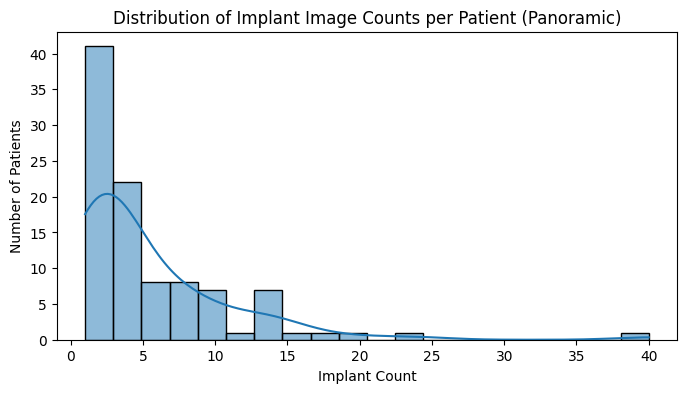

In [193]:
plt.figure(figsize=(8, 4))
sns.histplot(uniqueHN_pano_df["pano_count"], bins=20, kde=True)
plt.title("Distribution of Implant Image Counts per Patient (Panoramic)")
plt.xlabel("Implant Count")
plt.ylabel("Number of Patients")
plt.show()

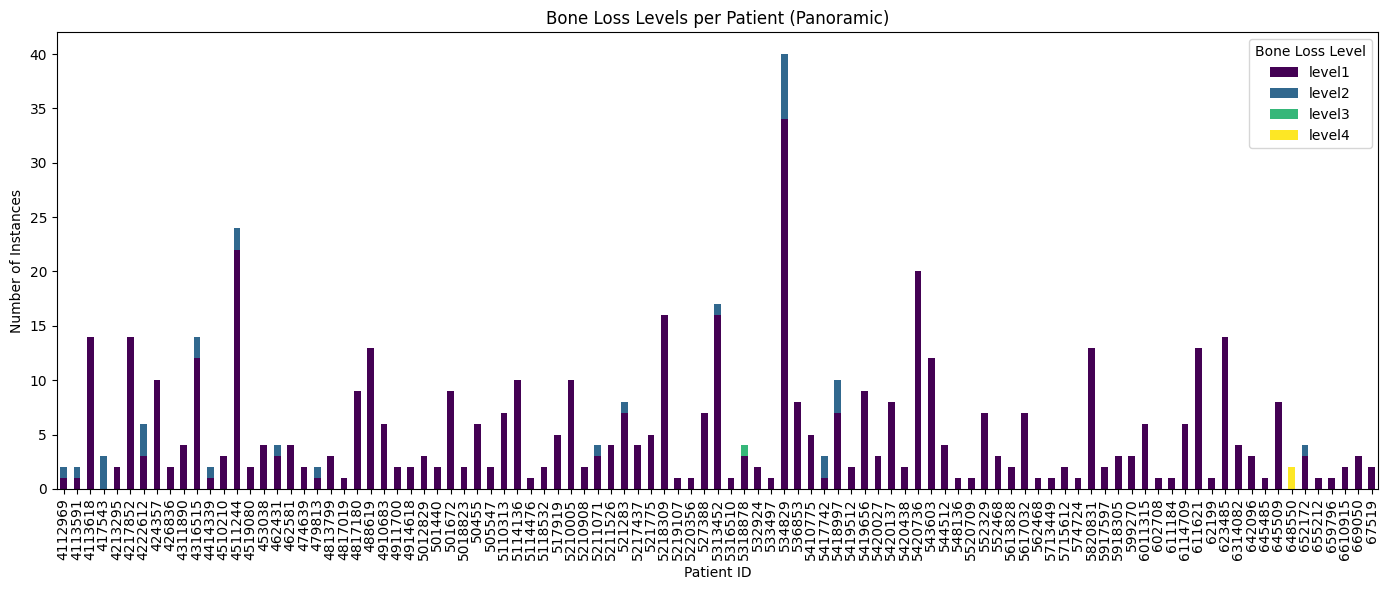

In [199]:
# Create a new dataframe for stacked bar plot
pano_bone_levels_df = uniqueHN_pano_df[["uniqueHN", "level1", "level2", "level3", "level4"]].set_index("uniqueHN")

# Plot
pano_bone_levels_df.plot(kind="bar", stacked=True, figsize=(14, 6), colormap="viridis")
plt.title("Bone Loss Levels per Patient (Panoramic)")
plt.xlabel("Patient ID")
plt.ylabel("Number of Instances")
plt.legend(title="Bone Loss Level")
plt.tight_layout()
plt.show()


In [208]:
level_sums = pano_bone_levels_df[["level1", "level2", "level3", "level4"]].sum()
print(level_sums)

level1    505
level2     30
level3      1
level4      2
dtype: int64


### Distribution of Peri

In [104]:
peri_df = datasets_df[datasets_df["img_type"] == "peri"]

uniqueHN_peri_df = peri_df.groupby("Patient ID").agg(
    peri_count=("img_type", "count"),
    level1=("boneloss_class", lambda x: np.sum(x == 1)),
    level2=("boneloss_class", lambda x: np.sum(x == 2)),
    level3=("boneloss_class", lambda x: np.sum(x == 3)),
    level4=("boneloss_class", lambda x: np.sum(x == 4))
).reset_index()

uniqueHN_peri_df = uniqueHN_peri_df.rename(columns={"Patient ID": "uniqueHN"})
uniqueHN_peri_df["uniqueHN"] = uniqueHN_peri_df["uniqueHN"].str.replace("-", "", regex=False)

In [105]:
display(uniqueHN_peri_df)

,uniqueHN,peri_count,level1,level2,level3,level4
0,505547,7,3,1,3,0
1,5111748,5,0,0,5,0
2,5318878,65,44,1,14,6
3,534829,46,29,9,6,2
4,5420736,69,64,4,1,0
5,5521865,7,6,1,0,0
6,62199,1,0,1,0,0
7,648550,7,0,0,1,6
8,6610915,5,4,1,0,0


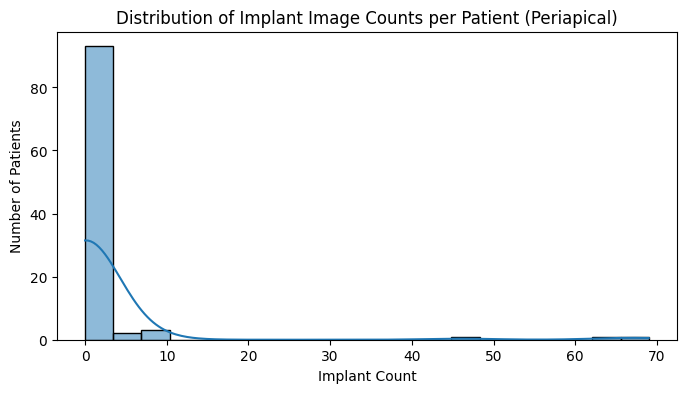

In [194]:
plt.figure(figsize=(8, 4))
sns.histplot(uniqueHN_df["peri_count"], bins=20, kde=True)
plt.title("Distribution of Implant Image Counts per Patient (Periapical)")
plt.xlabel("Implant Count")
plt.ylabel("Number of Patients")
plt.show()

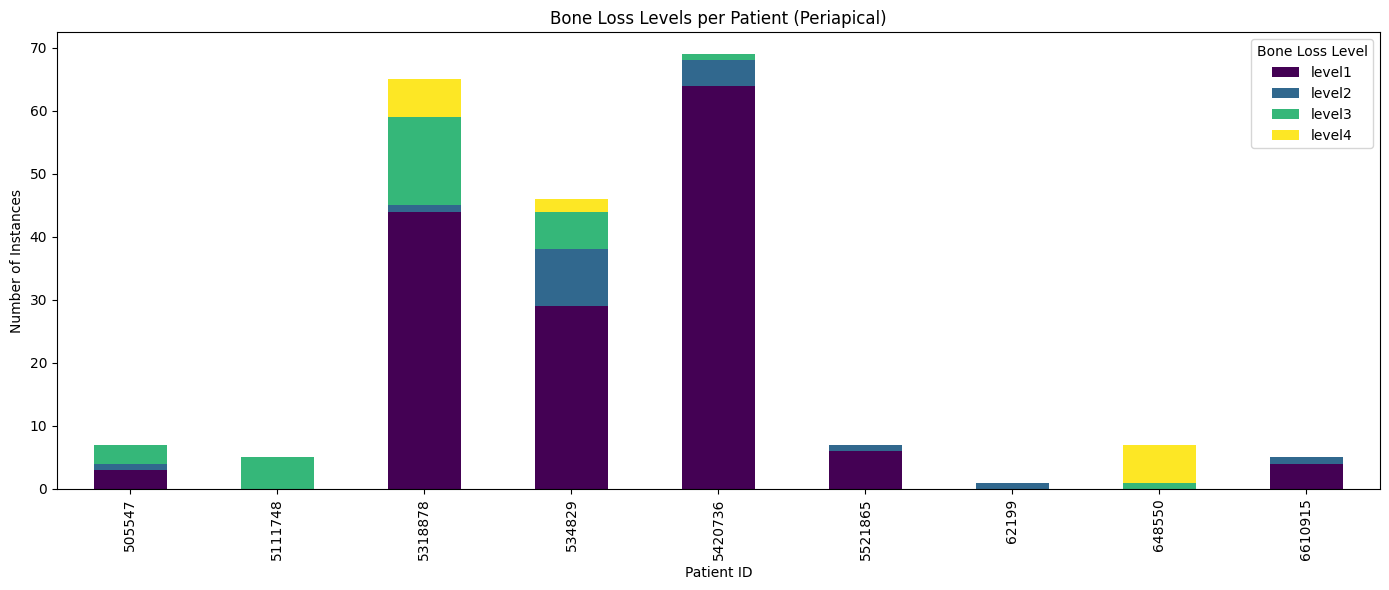

In [191]:
# Create a new dataframe for stacked bar plot
peri_bone_levels_df = uniqueHN_peri_df[["uniqueHN", "level1", "level2", "level3", "level4"]].set_index("uniqueHN")

# Plot
peri_bone_levels_df.plot(kind="bar", stacked=True, figsize=(14, 6), colormap="viridis")
plt.title("Bone Loss Levels per Patient (Periapical)")
plt.xlabel("Patient ID")
plt.ylabel("Number of Instances")
plt.legend(title="Bone Loss Level")
plt.tight_layout()
plt.show()

# Split the Datasets

In [109]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from collections import Counter

def stratified_split_by_levels(bone_levels_df, ratios=(0.8, 0.1, 0.1), random_state=42):
    """
    Split uniqueHN into train/val/test based on level presence.
    Ensures all bone loss levels appear and assigns single-patient tags to train.

    Parameters:
        bone_levels_df (pd.DataFrame): index=uniqueHN, columns=level1~level4
        ratios (tuple): (train_ratio, val_ratio, test_ratio)
        random_state (int): seed

    Returns:
        train_HNs, val_HNs, test_HNs: lists of uniqueHN
    """
    assert np.isclose(sum(ratios), 1.0), "Ratios must sum to 1.0"

    df = bone_levels_df.copy()

    # Create a "multi-label" tag like '1010'
    df['level_tag'] = df.apply(lambda row: ''.join([str(int(row[f'level{i}'] > 0)) for i in range(1, 5)]), axis=1)

    # Count tag frequency
    tag_counts = df['level_tag'].value_counts()

    # Assign unique tags (count == 1) to train
    unique_tags = tag_counts[tag_counts == 1].index
    unique_df = df[df['level_tag'].isin(unique_tags)]
    strat_df = df[~df['level_tag'].isin(unique_tags)]

    train_HNs = list(unique_df.index)

    # Stratified split for the remaining
    strat_train, strat_temp = train_test_split(
        strat_df.index,
        stratify=strat_df['level_tag'],
        test_size=(ratios[1] + ratios[2]),
        random_state=random_state
    )

    temp_df = strat_df.loc[strat_temp]
    temp_val_ratio = ratios[1] / (ratios[1] + ratios[2])

    strat_val, strat_test = train_test_split(
        temp_df.index,
        stratify=temp_df['level_tag'],
        test_size=(1 - temp_val_ratio),
        random_state=random_state
    )

    # Combine all
    train_HNs += list(strat_train)
    val_HNs = list(strat_val)
    test_HNs = list(strat_test)

    return train_HNs, val_HNs, test_HNs


In [181]:
def split_by_implant_image_count(bone_levels_df, ratios=(0.8, 0.1, 0.1), random_state=42):
    """
    Split uniqueHN into train/val/test:
    - Ensure 1 patient with level 4,3,2,1 in each split
    - Remaining patients split based on implant image count (ratio)

    Parameters:
        bone_levels_df (pd.DataFrame): index=uniqueHN, columns=level1~level4
        ratios (tuple): (train_ratio, val_ratio, test_ratio)
        random_state (int): seed

    Returns:
        train_HNs, val_HNs, test_HNs: lists of uniqueHN
    """
    assert np.isclose(sum(ratios), 1.0), "Ratios must sum to 1.0"
    np.random.seed(random_state)

    df = bone_levels_df.copy()
    df["implant_count"] = df[["level1", "level2", "level3", "level4"]].sum(axis=1)

    # Shuffle initially
    df = df.sample(frac=1, random_state=random_state)

    train_HNs, val_HNs, test_HNs = [], [], []
    train_count = val_count = test_count = 0
    assigned_HNs = set()

    def assign_level_to_splits(level_col):
        nonlocal train_count, val_count, test_count
        candidates = df[df[level_col] > 0]
        available = candidates[~candidates.index.isin(assigned_HNs)]

        if len(available) >= 3:
            selected = available.iloc[:3]
        else:
            selected = available

        for i, (hn, row) in enumerate(selected.iterrows()):
            count = row["implant_count"]
            if i == 0:
                train_HNs.append(hn)
                train_count += count
            elif i == 1:
                val_HNs.append(hn)
                val_count += count
            elif i == 2:
                test_HNs.append(hn)
                test_count += count
            assigned_HNs.add(hn)

    # First assign a petients to all level to train/val/test
    assign_level_to_splits("level4")
    assign_level_to_splits("level3")
    # assign_level_to_splits("level2")
    # assign_level_to_splits("level1")


    # Remove already assigned HNs
    remaining_df = df[~df.index.isin(assigned_HNs)]

    # Target implant image counts
    total_implants = df["implant_count"].sum()
    target_train = ratios[0] * total_implants
    target_val = ratios[1] * total_implants
    target_test = ratios[2] * total_implants

    # Assign remaining patients based on implant count
    for hn, row in remaining_df.iterrows():
        count = row["implant_count"]
        if train_count + count <= target_train:
            train_HNs.append(hn)
            train_count += count
        elif val_count + count <= target_val:
            val_HNs.append(hn)
            val_count += count
        else:
            test_HNs.append(hn)
            test_count += count

    return train_HNs, val_HNs, test_HNs


In [200]:
def print_level_counts(df, split_HNs, name=""):
    subset = df.loc[split_HNs]
    level_sums = subset[["level1", "level2", "level3", "level4"]].sum()
    print(f"\n{name} Split — {len(split_HNs)} Patients")
    print(level_sums)
    print(f"Total implant images: {level_sums.sum()}")


In [218]:
def save_list_to_txt(data_list, filename):
    with open(filename, 'w') as f:
        for item in data_list:
            f.write(f"{item}\n")

## 1. Pano

In [209]:
pano_train_HNs, pano_val_HNs, pano_test_HNs = split_by_implant_image_count(pano_bone_levels_df, ratios=(0.8, 0.1, 0.1))


In [212]:
print(f"Train Patients: {len(pano_train_HNs)}")
print(f"Val Patients: {len(pano_val_HNs)}")
print(f"Test Patients: {len(pano_test_HNs)}\n")

print("Implants in each:")
print("Train:", pano_bone_levels_df.loc[pano_train_HNs][["level1", "level2", "level3", "level4"]].sum().sum())
print("Val:", pano_bone_levels_df.loc[pano_val_HNs][["level1", "level2", "level3", "level4"]].sum().sum())
print("Test:", pano_bone_levels_df.loc[pano_test_HNs][["level1", "level2", "level3", "level4"]].sum().sum())

Train Patients: 76
Val Patients: 17
Test Patients: 6

Implants in each:
Train: 430
Val: 53
Test: 55


In [213]:
print_level_counts(pano_bone_levels_df, pano_train_HNs, name="Train")
print_level_counts(pano_bone_levels_df, pano_val_HNs, name="Val")
print_level_counts(pano_bone_levels_df, pano_test_HNs, name="Test")


Train Split — 76 Patients
level1    401
level2     26
level3      1
level4      2
dtype: int64
Total implant images: 430

Val Split — 17 Patients
level1    49
level2     4
level3     0
level4     0
dtype: int64
Total implant images: 53

Test Split — 6 Patients
level1    55
level2     0
level3     0
level4     0
dtype: int64
Total implant images: 55


the split result don't have level4 in val and test because there is only 1 patient that have level4

In [220]:
#save
save_list_to_txt(pano_train_HNs, "/content/pano_train.txt")
save_list_to_txt(pano_val_HNs, "/content/pano_val.txt")
save_list_to_txt(pano_test_HNs, "/content/pano_test.txt")

## 2. Pano + peri

In [183]:
all_train_HNs, all_val_HNs, all_test_HNs = split_by_implant_image_count(bone_levels_df, ratios=(0.8, 0.1, 0.1))


In [184]:
print(f"Train Patients: {len(all_train_HNs)}")
print(f"Val Patients: {len(all_val_HNs)}")
print(f"Test Patients: {len(all_test_HNs)}\n")

print("Implants in each:")
print("Train:", bone_levels_df.loc[all_train_HNs][["level1", "level2", "level3", "level4"]].sum().sum())
print("Val:", bone_levels_df.loc[all_val_HNs][["level1", "level2", "level3", "level4"]].sum().sum())
print("Test:", bone_levels_df.loc[all_test_HNs][["level1", "level2", "level3", "level4"]].sum().sum())

Train Patients: 97
Val Patients: 2
Test Patients: 2

Implants in each:
Train: 574
Val: 98
Test: 78


In [185]:
print_level_counts(bone_levels_df, all_train_HNs, name="Train")
print_level_counts(bone_levels_df, all_val_HNs, name="Val")
print_level_counts(bone_levels_df, all_test_HNs, name="Test")


Train Split — 97 Patients
level1    519
level2     42
level3     11
level4      2
dtype: int64
Total implant images: 574

Val Split — 2 Patients
level1    84
level2     4
level3     2
level4     8
dtype: int64
Total implant images: 98

Test Split — 2 Patients
level1    52
level2     2
level3    18
level4     6
dtype: int64
Total implant images: 78


In [221]:
save_list_to_txt(all_train_HNs, "/content/all_train.txt")
save_list_to_txt(all_val_HNs, "/content/all_val.txt")
save_list_to_txt(all_val_HNs, "/content/all_test.txt")

# See image count

In [238]:
def assign_split_labels(train_HN_list, val_HN_list, test_HN_list, datasets_df):
    df = datasets_df[["id", "Patient ID"]].copy()

    def get_split(patient_id):
        if patient_id in train_HN_list:
            return "train"
        elif patient_id in val_HN_list:
            return "val"
        elif patient_id in test_HN_list:
            return "test"
        else:
            return "unknown"  # Optional: handle IDs not in any list

    df["split"] = df["Patient ID"].apply(get_split)
    df = df.drop_duplicates(subset="id")
    return df


In [246]:
def print_split_ratios(split_df):
    split_counts = split_df["split"].value_counts()
    counts = split_counts.reindex(["train", "val", "test"], fill_value=0)

    train_count = counts["train"]
    val_count = counts["val"]
    test_count = counts["test"]
    total = train_count + val_count + test_count

    if total == 0:
        print("No data to compute ratios.")
        return

    train_ratio = train_count / total
    val_ratio = val_count / total
    test_ratio = test_count / total

    print(f"Train : Val : Test = {train_ratio:.2f} : {val_ratio:.2f} : {test_ratio:.2f}")


## Pano

In [239]:
datasets_df['Patient ID'] = datasets_df['Patient ID'].str.replace("-", "", regex=False)

In [240]:
pano_df['Patient ID'] = pano_df['Patient ID'].str.replace("-", "", regex=False)

<ipython-input-240-064072f773ae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pano_df['Patient ID'] = pano_df['Patient ID'].str.replace("-", "", regex=False)


In [241]:
pano_split_df = assign_split_labels(pano_train_HNs, pano_val_HNs, pano_test_HNs, pano_df)

In [242]:
pano_split_counts = pano_split_df["split"].value_counts()
print(pano_split_counts)

split
train    146
val       27
test      16
Name: count, dtype: int64


In [247]:
print_split_ratios(pano_split_df)

Train : Val : Test = 0.77 : 0.14 : 0.08


In [251]:
#save
pano_split_df.to_csv("/content/pano_split.csv", index=False)

## Pano + Peri

In [243]:
all_split_df = assign_split_labels(all_train_HNs, all_val_HNs, all_test_HNs, datasets_df)

In [244]:
all_split_counts = all_split_df["split"].value_counts()
print(all_split_counts)

split
train    230
test      53
val       52
Name: count, dtype: int64


In [248]:
print_split_ratios(all_split_df)

Train : Val : Test = 0.69 : 0.16 : 0.16


In [252]:
#save
all_split_df.to_csv("/content/all_split.csv", index=False)